<h1>Klasifikasi Dokumen Berita BBC</h1>

Proyek ini bertujuan untuk mengklasifikasikan dokumen menggunakan Jaringan Saraf Tiruan (JST) (<i>Artificial Neural Network (ANN)</i>). Pada proyek ini kami juga akan menggunakan algoritma non JST yaitu : KNN sebagai metode pembanding. Score TF-IDF akan digunakan sebagai fitur dalam proyek ini, yang dimana selanjutnya dijadikan input untuk jaringan Saraf Tiruan. Dari proses training ini diharapkan mampu menghasilkan model yang handal dalam melakukan klasifikasi dokumen. Adapun alur proyek yang diadaptasikan dalam proyek ini adalah sebagai berikut :
<ol>
  <li>Load Dataset</li>
  <li>Preprocessing Data</li>
    <ul>
      <li>Lowercasing</li>
      <li>Tokenisasi</li>
      <li>Cleaning</li>
      <li>Stopword</li>
      <li>Steming</li>
      <li>Lematisasi</li>
      <li>Data Spliting</li>
    </ul>
  <li>Features Reduction(Optional)</li>
    <ul>
      <li>PCA</li>
      <li>Chi-Square</li>
    </ul>
  <li>Training Phase</li>
    <ul>
      <li>Backpropagation</li>
      <li>RNN</li>
      <li>KNN</li>
    </ul>
  <li>Testing Phase</li>
  <li>Result</li>
    <ul>
      <li>Confusion Matrix</li>
      <li>Accuracy</li>
      <li>Precision</li>
      <li>Recall</li>
      <li>F1 Score</li>
    </ul>
</ol>

<h2>Load Dataset</h2>

Dataset yang digunakan adalah <a href ="https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification">BBC Full Text Document Classification</a>. Dataset ini terdiri atas 2225 dokumen yang dikurasi dari website berita BBC dengan 5 kategori (bussines, entertainment, politics, sport dan tech). Dataset ini dikurasi dari tahun 2004 - 2005.

Sitasi : D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

In [8]:
# Data manipulation libraries.
import numpy as np
import pandas as pd
import spacy

# Data visualization libraries.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# General Imports
import os
import re
from tqdm import tqdm
from colorama import Fore, Style
from collections import Counter


# Library versions.
print("NumPy version:", np.__version__)
print("Spacy version:", spacy.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

NumPy version: 1.26.0
Spacy version: 3.7.1
Pandas version: 2.1.1
Matplotlib version: 3.8.0
Seaborn version: 0.13.0


<h3>Konstanta</h3>

In [12]:
DATA_DIR = "dataset/"
METADATA_CSV = "doc_metadata.csv"

<h3>Daftar Fungsi</h3>

In [63]:
def display_as_table(headers, rows, align="r", add_sl_no=False):
    if isinstance(rows, pd.Series):
        rows = list(rows.iteritems())

    table = PrettyTable(align=align)

    if add_sl_no:
        table.field_names = ["No."] + list(headers)
        table.align["No."] = "r"
        rows = [[idx + 1] + list(row) for idx, row in enumerate(rows)]
    else:
        table.field_names = headers

    table.add_rows(rows)
    display(table)


to_dict = lambda frm_list: {item: frm_list.index(item) for item in frm_list}

In [23]:
meta_data = []

folder_kategori = os.listdir(DATA_DIR)

for kategori in folder_kategori:
    path_kategori = os.path.join(DATA_DIR, kategori)
    if not os.path.isdir(path_kategori):
        continue

    nama_docs = os.listdir(path_kategori)
    for doc in nama_docs:
        path_doc = path_kategori + "/" + doc
        ukuran_doc = os.path.getsize(path_doc)
        nama_doc, ext = os.path.splitext(doc) 
        doc_id = kategori[0].upper() + "_" + nama_doc
        meta_data.append([kategori.capitalize(), doc_id, ukuran_doc, path_doc])

nama_kolom = ["Doc_Kategori", "Id_Doc", "Ukuran_Doc", "Path_Doc"]
meta_df = pd.DataFrame(data=meta_data, columns=nama_kolom)

meta_df.to_csv(METADATA_CSV, index=False, na_rep="")

meta_df["Doc_Kategori"] = meta_df["Doc_Kategori"].astype("category")

meta_df.sample(10)


,Doc_Kategori,Id_Doc,Ukuran_Doc,Path_Doc
1257,Politics,P_362,3427,dataset/politics/362.txt
600,Entertainment,E_091,1163,dataset/entertainment/091.txt
1547,Sport,S_235,4437,dataset/sport/235.txt
227,Business,B_228,1329,dataset/business/228.txt
1845,Tech,T_022,1794,dataset/tech/022.txt
1098,Politics,P_203,2529,dataset/politics/203.txt
2102,Tech,T_279,2391,dataset/tech/279.txt
2110,Tech,T_287,1945,dataset/tech/287.txt
1870,Tech,T_047,1835,dataset/tech/047.txt
1885,Tech,T_062,2482,dataset/tech/062.txt


In [25]:
baris, kolom = meta_df.shape
print(f"Dataset terdiri dari {baris} baris and {kolom} kolom.\n")

meta_df.info()

Dataset terdiri dari 2225 baris and 4 kolom.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Doc_Kategori  2225 non-null   category
 1   Id_Doc        2225 non-null   object  
 2   Ukuran_Doc    2225 non-null   int64   
 3   Path_Doc      2225 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 54.7+ KB


Tidak ada data yang <i>missing</i>

<h3>Label Kategori</h3>

In [60]:
jum_kategori = meta_df["Doc_Kategori"].value_counts()

display_as_table(
  headers = ["Label Kategori", "Jumlah"],
  rows = list(zip(jum_kategori.index, jum_kategori.values)),
  add_sl_no = True
)

No.,Label Kategori,Jumlah
1,Sport,511
2,Business,510
3,Politics,417
4,Tech,401
5,Entertainment,386


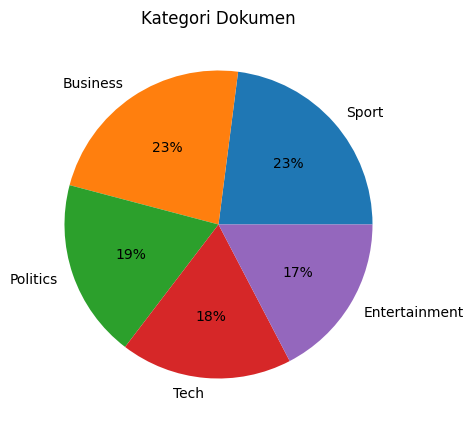

In [62]:
plt.figure(figsize=(5, 5))

plt.pie(x=jum_kategori, labels=jum_kategori.index, autopct="%1.0f%%")
plt.title("Kategori Dokumen")

plt.show()

In [64]:
codes, uniques = pd.factorize(meta_df["Doc_Kategori"])

cls_map = to_dict(uniques.categories.to_list())
print("Encoded class-labels:\n", cls_map)

meta_df["DocCat"] = codes
meta_df["DocCat"].value_counts().sort_index()

Encoded class-labels:
 {'Business': 0, 'Entertainment': 1, 'Politics': 2, 'Sport': 3, 'Tech': 4}


DocCat
0    510
1    386
2    417
3    511
4    401
Name: count, dtype: int64

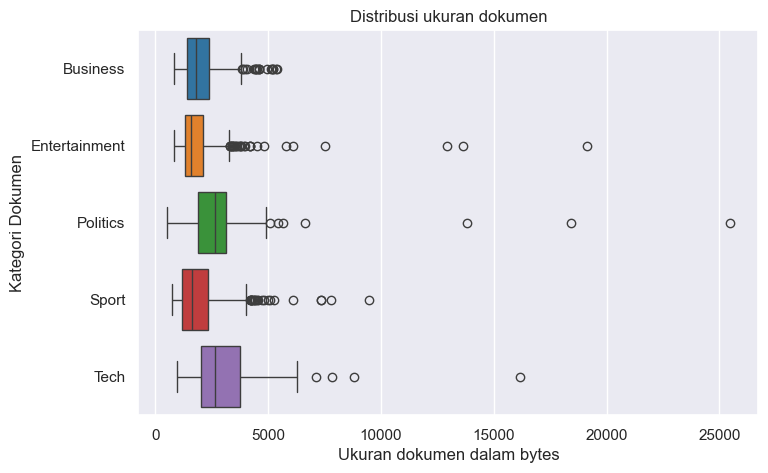

In [92]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=meta_df, x="Ukuran_Doc", y="Doc_Kategori", palette="tab10", hue="Doc_Kategori", legend=False)
plt.title("Distribusi ukuran dokumen")
plt.xlabel("Ukuran dokumen dalam bytes")
plt.ylabel("Kategori Dokumen")

plt.show()